In [1]:
import os
import sys
import pathlib
import subprocess
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ruamel.yaml

# define script parameters
threshold = [0, 100, 250, 500, 750, 1000]
method = ["merge", "prune_merge", "prune_snap_merge"]
dt = [300,100,10]
tw = 933020089
nts = 8640

# define filepaths
root = pathlib.Path("..").resolve()
output_dir = os.path.join(root, "test", "output", "text")
routelink_path = os.path.join(root,"test","input","geo","Channels")
yaml_dir = os.path.join(root,"test","input","yaml")


# Construct augmented networks

In [ ]:
for m in method:
    
    for t in threshold:
        
        if t!= 0:
        
            if m == "merge":
                cmd_strs = [
                    "python", 
                    "nhd_network_augment.py",
                    "-t",
                    str(t), 
                    "--network",
                    "Florence_FULL_RES"]

            if m == "prune_merge":
                cmd_strs = [
                    "python", 
                    "nhd_network_augment.py",
                    "-t",
                    str(t), 
                    "--network",
                    "Florence_FULL_RES",
                    "-p"]

            if m == "prune_snap_merge":
                cmd_strs = [
                    "python", 
                    "nhd_network_augment.py",
                    "-t",
                    str(t), 
                    "--network",
                    "Florence_FULL_RES",
                    "-p",
                    "-s"] 

            subprocess.run(
                cmd_strs,
                cwd=os.path.join(root,"src","python_framework_v02","troute")
            )
       

# Run Muskingum-Cunge routing model on augmented networks

In [3]:
n_violation = []
pct_violation = []
av_violation = []
pct_violation = []
method_list = []
threshold_list = []
outlet_flow = []
for m in method:
    
    for t in threshold:
        
        method_list.extend([m])
        threshold_list.extend([t])

        dir_name  = "RouteLink_Florence_FULL_RES_"+str(t)+"m_"+m  
        routelink_name = dir_name+".pkl"
        crosswalk_name = "CrossWalk_Florence_FULL_RES_"+str(t)+"m_"+m+".json"
        
        if t != 0:
            # edit yaml file - Florence_Benchmark-augment.yaml
            yaml = ruamel.yaml.YAML()
            with open(os.path.join(yaml_dir,'Florence_Benchmark.yaml')) as fp:
                data = yaml.load(fp)

            data['supernetwork_parameters']['title_string'] = "Florence_TEST_" + str(t) + "m_" + m
            data['supernetwork_parameters']['run_augmented_network'] = True        
            data['supernetwork_parameters']['augment_routelink'] = os.path.join(routelink_path,dir_name,routelink_name)
            data['supernetwork_parameters']['cross_walk'] = os.path.join(routelink_path,dir_name,crosswalk_name)

            new_yaml_name = "Florence_Benchmark_" + str(t) +"m_" + m + ".yaml"
            with open(os.path.join(yaml_dir,new_yaml_name), "w") as f:
                yaml.dump(data, f)
        else:
            new_yaml_name = "Florence_Benchmark.yaml"

        # execute the model
        print("Running t-route with threshold length of", t, "and method:", m, "...")
        
        subprocess.run(
        [
            "python", 
            "compute_nhd_routing_SingleSeg_v02.py",
            "-f",
            "../../test/input/yaml/" + new_yaml_name, 
            "-v"],
        cwd=os.path.join(root,"src","python_routing_v02"),
        )
        
        # get Courant data
        if t == 0:
            dat_c = pd.read_csv(os.path.join(output_dir, "courant_Florence_TEST.csv"), index_col=[1]) 
        else:
            filename = "courant_Florence_TEST_" + str(t) + "m_" + m + ".csv" 
            dat_c = pd.read_csv(os.path.join(output_dir, filename), index_col=[1]) 
            
        n_violation.extend([dat_c.loc["n_violation"].value])
        av_violation.extend([dat_c.loc["av_violation"].value])
        pct_violation.extend([dat_c.loc["pct_violation"].value])
        
        # extract flow at outlet node
        if t == 0:
            dat_f = pd.read_csv(os.path.join(output_dir, "flowveldepth_Florence_TEST.csv"), index_col=[0])  
        else:
            filename = "flowveldepth_Florence_TEST_" + str(t) + "m_" + m + ".csv"
            dat_f = pd.read_csv(os.path.join(output_dir, filename), index_col=[0]) 

        outlet_flow.append(dat_f.loc[tw].values)
        
simtime = dat_f.columns.values.astype('float32')

# Package courant results in a dataframe
courant_augment_sensitivity = pd.DataFrame(
    {'threshold_length': threshold_list,
     'method': method_list,
     'n_violation': n_violation,
     'av_violation': av_violation,
     'pct_violation': pct_violation}
)

# package Flow results in dataframe
B = np.concatenate([np.array(x)[None,:] for x in outlet_flow], axis=0)
flow_augment_sensitivity = pd.DataFrame(data = B)
flow_augment_sensitivity.columns = simtime
flow_augment_sensitivity.insert(loc=0, column='threshold_length', value=courant_augment_sensitivity["threshold_length"])
flow_augment_sensitivity.insert(loc=1, column='method', value=courant_augment_sensitivity["method"])
flow_augment_sensitivity = flow_augment_sensitivity.melt(id_vars = ['threshold_length','method'], value_vars = simtime, var_name = "Simulation Time (dys)", value_name = "Flow (cms)")


Running t-route with threshold length of 0 and method: merge ...
Running t-route with threshold length of 100 and method: merge ...
Running t-route with threshold length of 250 and method: merge ...
Running t-route with threshold length of 500 and method: merge ...
Running t-route with threshold length of 750 and method: merge ...
Running t-route with threshold length of 1000 and method: merge ...
Running t-route with threshold length of 0 and method: prune_merge ...
Running t-route with threshold length of 100 and method: prune_merge ...
Running t-route with threshold length of 250 and method: prune_merge ...
Running t-route with threshold length of 500 and method: prune_merge ...
Running t-route with threshold length of 750 and method: prune_merge ...
Running t-route with threshold length of 1000 and method: prune_merge ...
Running t-route with threshold length of 0 and method: prune_snap_merge ...
Running t-route with threshold length of 100 and method: prune_snap_merge ...
Running 

# Run Muskingum-Cunge model over a range of timesteps

In [4]:
n_violation = []
pct_violation = []
av_violation = []
outlet_flow = []
simtime = []
for t in dt:
    
    # edit yaml file - Florence_Benchmark-augment.yaml
    yaml = ruamel.yaml.YAML()
    with open(os.path.join(yaml_dir,'Florence_Benchmark.yaml')) as fp:
        data = yaml.load(fp)

    data['run_parameters']['dt'] = t
    data['run_parameters']['qts_subdivisions'] = int(3600/t)
    data['run_parameters']['nts'] = int((30*86400)/t)
    data['supernetwork_parameters']['title_string'] = "Florence_TEST_" + str(t) + "secs"      

    new_yaml_name = "Florence_Benchmark_" + str(t) + "secs" ".yaml"
    with open(os.path.join(yaml_dir,new_yaml_name), "w") as f:
        yaml.dump(data, f)
        
    # execute the model
    print("Running t-route with a", t, "second timestep")

    subprocess.run(
    [
        "python", 
        "compute_nhd_routing_SingleSeg_v02.py",
        "-f",
        "../../test/input/yaml/" + new_yaml_name, 
        "-v"],
    cwd=os.path.join(root,"src","python_routing_v02"),
    )
    
    # extract courant metrics
    filename = "courant_Florence_TEST_" + str(t) + "secs.csv"
    dat_c = pd.read_csv(os.path.join(output_dir, filename), index_col=[1]) 
    n_violation.extend([dat_c.loc["n_violation"].value])
    av_violation.extend([dat_c.loc["av_violation"].value])
    pct_violation.extend([dat_c.loc["pct_violation"].value])
    
    # extract flow timeseries
    filename = "flowveldepth_Florence_TEST_" + str(t) + "secs.csv"
    dat_f = pd.read_csv(os.path.join(output_dir, filename), index_col=[0]) 
    outlet_flow.append(dat_f.loc[tw].values)
    simtime.append(dat_f.columns.values.astype('float32'))
    
# place Courant data in DataFrame
courant_dt_sensitivity = pd.DataFrame(
    {'dt (secs)': dt,
     'n_violation': n_violation,
     'av_violation': av_violation,
     'pct_violation': pct_violation}
)
courant_dt_sensitivity = courant_dt_sensitivity.set_index('dt (secs)')

# Join flow data into dataframe
i = dt.index(300)
outlet_flow_join = []
outlet_flow_join.append(outlet_flow[i])
for j, t in enumerate(dt, start = 0):
    if t != 300:
        x, i_x, i_y = np.intersect1d(simtime[i],simtime[j],return_indices=True)
        outlet_flow_join.append(outlet_flow[j][i_y])
        
B = np.concatenate([np.array(x)[None,:] for x in outlet_flow_join], axis=0)
flow_dt_sensitivity = pd.DataFrame(data = B)
flow_dt_sensitivity.columns = simtime[i]
flow_dt_sensitivity.insert(loc=0, column='dt (secs)', value=dt)
flow_dt_sensitivity = flow_dt_sensitivity.melt(id_vars = ['dt (secs)'], value_vars =  simtime[i], var_name = "Simulation Time (dys)", value_name = "Flow (cms)")
flow_dt_sensitivity = flow_dt_sensitivity.set_index('dt (secs)')


Running t-route with a 300 second timestep
Running t-route with a 100 second timestep
Running t-route with a 10 second timestep


# Plot sensitivity of flow to timestep

Text(0.5, 1.0, 'Timestep sensitivity')

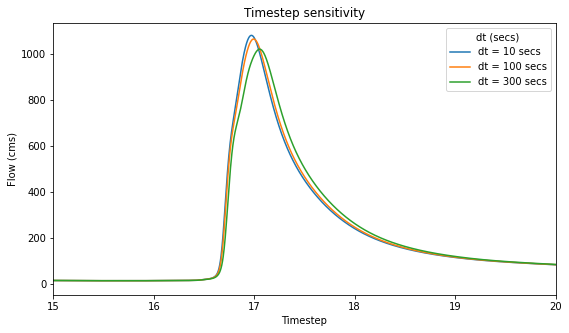

In [5]:
df_plot = (flow_dt_sensitivity.
             reset_index().
             pivot(index = "Simulation Time (dys)", columns = "dt (secs)", values = "Flow (cms)").
             rename(columns = {10:"dt = 10 secs",
                               100:"dt = 100 secs",
                               300: "dt = 300 secs"})
            )

ax = df_plot.plot(
    xlim = [15,20],
    figsize = (9,5)
)
ax.set_ylabel("Flow (cms)")
ax.set_xlabel("Timestep")
ax.set_title("Timestep sensitivity")

# Which augmentation method best reproduces the 10-second (near-stable) hydrograph?

In [6]:
# which augmented simulation best aligns with the short timestep simulaton?
flow_10 = (flow_dt_sensitivity.
                 reset_index().
                 rename(columns = {"dt (secs)":"dt"}).
                 query('dt == 10').
                 set_index("Simulation Time (dys)"))[["Flow (cms)"]]

RMSE = []
for m in method:
    
    for t in threshold:
        
        flow_augmented = (flow_augment_sensitivity.
                 query('method == @m and threshold_length == @t').
                 set_index("Simulation Time (dys)"))[["Flow (cms)"]]
        
        flow_join = flow_augmented.join(flow_10, on = "Simulation Time (dys)", how = "left", lsuffix='_left', rsuffix='_right')
        
        flow_join["Sq. Error"] = np.square(np.absolute(flow_join["Flow (cms)_left"] - flow_join["Flow (cms)_right"]))
        RMSE.extend([np.sqrt(flow_join["Sq. Error"].mean())])
        

compare_result = pd.DataFrame(
    {'threshold_length': threshold_list,
     'method': method_list,
     'RMSE': RMSE}
)

print(compare_result)


    threshold_length            method       RMSE
0                  0             merge  18.286814
1                100             merge  16.778195
2                250             merge  14.944907
3                500             merge  14.193527
4                750             merge  13.865842
5               1000             merge  12.252902
6                  0       prune_merge  18.286814
7                100       prune_merge  16.626563
8                250       prune_merge  12.646454
9                500       prune_merge   8.374558
10               750       prune_merge   7.528856
11              1000       prune_merge  21.285800
12                 0  prune_snap_merge  18.286814
13               100  prune_snap_merge  16.626452
14               250  prune_snap_merge  12.649530
15               500  prune_snap_merge   8.345717
16               750  prune_snap_merge   7.643583
17              1000  prune_snap_merge  20.122659


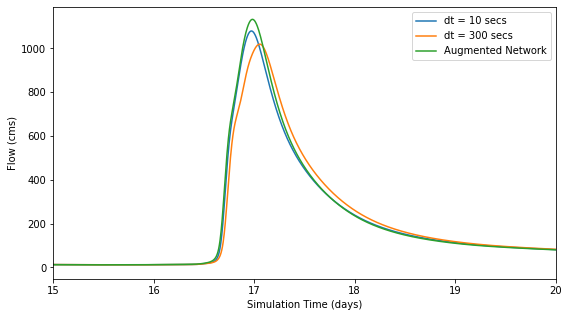

In [7]:
m = "prune_snap_merge"
t = 750

flow_plot = (flow_dt_sensitivity.
                 reset_index().
                 rename(columns = {"dt (secs)":"dt"}).
                 query('dt == 10 or dt == 300').
                 pivot(index = "Simulation Time (dys)", columns = "dt", values = "Flow (cms)").
                 rename(columns = {10:"dt = 10 secs", 300:"dt = 300 secs"}).
                 join(flow_augment_sensitivity.query('method == @m and threshold_length == @t').set_index("Simulation Time (dys)").rename(columns = {"Flow (cms)":"Augmented Network"})[["Augmented Network"]],
                       on = "Simulation Time (dys)", 
                       how = "left", lsuffix='_left', 
                       rsuffix='_right')
            )

ax = flow_plot.plot(
    xlim = [15,20],
    figsize = (9,5)
)
ax.set_ylabel("Flow (cms)")
ax.set_xlabel("Simulation Time (days)")
plt.legend(loc='upper right')

plt.show()

# save sensitivity results as .pkl files

In [8]:
pkl_dir = os.path.join(root, "test", "output")

(flow_dt_sensitivity.
 to_pickle(os.path.join(pkl_dir,"flow_dt_sensitivity.pkl"))
)

(courant_dt_sensitivity.
 to_pickle(os.path.join(pkl_dir,"courant_dt_sensitivity.pkl"))
)

(courant_augment_sensitivity.
 set_index(["threshold_length","method"]).
 to_pickle(os.path.join(pkl_dir,"courant_augment_sensitivity.pkl"))
)

(flow_augment_sensitivity.
 set_index(["threshold_length","method"]).
 to_pickle(os.path.join(pkl_dir,"flow_augment_sensitivity.pkl"))
)

In [ ]:
pkl_dir = os.path.join(root, "test", "output")
(flow_augment_sensitivity.
 set_index(["threshold_length","method"]).
 to_pickle(os.path.join(pkl_dir,"flow_augment_sensitivity.pkl"))
)